Jordan Weintraub

### Imports

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile #read in the zip file on returns 
from io import BytesIO
from urllib.request import urlopen
import requests
import zipfile
import os
from requests_html import HTMLSession # HTMLSession is how requests_html loads requests
import urllib.request
import re

import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
import statsmodels.api as sm



### Read in the file containing returns data 

Have to open a file that contains stock returns for 2019-2020. However, the data file is in a zip and the file I want is inside so it makes things more difficult. 

Necessary steps:
- read in the raw url to the zip
- open the zip
- read through the files in the zip
- open the file we are looking for and extract it
- turn the data file into a dataframe

In [2]:
# specifying the zip file name
file_name ='https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/2019-2020-stock_rets%20cleaned.zip?raw=true'
resp = urlopen(file_name) #open url of the zip 
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist() #add the files within the zip to a list 
extracted_file = zipfile.open('2019-2020-stock_rets cleaned.dta') #pull the dta file
#extracted_file

returns = pd.read_stata(extracted_file) #dataframe of the firm daily returns 

#returns
#returns['ticker'].nunique() #2,206 firms with returns 
returns

,permno,date,ticker,comnam,primexch,prc,ret,shrout,vwretd,_merge
0,10026,20191025,JJSF,J & J SNACK FOODS CORP,Q,188.960007,-0.005997,18895.0,0.004069,matched (3)
1,10026,20200311,JJSF,J & J SNACK FOODS CORP,Q,146.199997,-0.066232,18919.0,-0.049958,matched (3)
2,10026,20200108,JJSF,J & J SNACK FOODS CORP,Q,182.039993,-0.005409,18900.0,0.004028,matched (3)
3,10026,20200413,JJSF,J & J SNACK FOODS CORP,Q,121.930000,-0.045334,18888.0,-0.010146,matched (3)
4,10026,20200602,JJSF,J & J SNACK FOODS CORP,Q,128.740005,-0.018076,18888.0,0.008413,matched (3)
...,...,...,...,...,...,...,...,...,...,...
724220,93436,20190425,TSLA,TESLA INC,Q,247.630005,-0.042643,173721.0,-0.001464,matched (3)
724221,93436,20190619,TSLA,TESLA INC,Q,226.429993,0.007520,177270.0,0.003742,matched (3)
724222,93436,20190927,TSLA,TESLA INC,Q,242.130005,-0.001773,179127.0,-0.005689,matched (3)
724223,93436,20191219,TSLA,TESLA INC,Q,404.040009,0.027699,180245.0,0.004193,matched (3)


### Get the gross returns for each firm for a certain week

Necessary steps:
- change the format of the dates to datetime format
- change the return values to be numeric
- filter the dataset to only have 2020 gross returns from March 9th to March 13th 
- calculate the gross returns for the week
- assign data to 'Returns'

In [3]:
returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format 
returns.sort_values(by='date') # This now sorts in date order
returns['ret'] = returns['ret'].apply(pd.to_numeric, errors='coerce') #had to change the ret to numeric values 

returns['Gross_Ret'] = 1 + returns['ret']

subsample = (returns[(returns['date'] >= '2020-03-09') & (returns['date'] <= '2020-03-13')]) #group returns data within a time range 
Returns = (subsample.groupby(['ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
Returns
#Returns.mean() #down 14%... oof

,ticker,Gross_Ret
0,A,-0.119144
1,AA,-0.273389
2,AAL,-0.103944
3,AAN,-0.133448
4,AAON,-0.116500
...,...,...
1911,ZM,-0.059920
1912,ZNGA,-0.072238
1913,ZS,-0.151853
1914,ZTO,-0.037593


### BONUS: Calculate the gross returns for the week
Bonus: getting gross returns for each firm for the collapse period 

Necessary steps:
- filter the dataset to only have 2020 gross returns from Febuary 23 to March 23rd 
- calculate the gross returns for the month
- assign data to 'collapse_ret'


In [4]:
#BONUS
collapse_prd = (returns[(returns['date'] >= '2020-02-23') & (returns['date'] <= '2020-03-23')])
collapse_ret=(collapse_prd.groupby('ticker')['Gross_Ret'].prod()-1).reset_index()
collapse_ret
#collapse_ret.mean() #down 38%... ouch

,ticker,Gross_Ret
0,A,-0.255082
1,AA,-0.647826
2,AAL,-0.631560
3,AAN,-0.636407
4,AAON,-0.135669
...,...,...
1915,ZM,0.568002
1916,ZNGA,-0.122020
1917,ZS,0.064574
1918,ZTO,-0.044497


### BONUS: Getting gross returns for each firm for the day stimulus package was released 

Necessary steps:
- filter the dataset to only have 2020 gross returns for March 24th  
- calculate the gross returns
- assign data to 'Stimmy_ret'



In [5]:
#BONUS
Stimmy = (returns[(returns['date'] == '2020-03-24')])
Stimmy_ret = (Stimmy.groupby('ticker')['Gross_Ret'].prod()-1).reset_index() #only 1 day so can use .prod or .mean
Stimmy_ret
#can see that we have less return data on this day compared to the collapse period and the covid week we are measuring 
#Stimmy_ret.mean() #up 10%... yippie 

,ticker,Gross_Ret
0,A,0.057283
1,AA,0.282187
2,AAL,0.358049
3,AAN,0.323791
4,AAON,-0.047330
...,...,...
1908,ZM,-0.152795
1909,ZNGA,0.019169
1910,ZS,0.070825
1911,ZTO,0.038103


### Merging necessary datasets  

Necessary steps:
- read in the csv file containing accounting information
- delete the _merge column if it already exists 
- perform left merge on the ticker symbol for a one to one relationship 
- perform value count

Notice how after merging the two datasets, I applied a value counts to see where all the data came from. We see that 495 counts came from both datasets, while 10 values came from only the left dataset. In other words, we were only able to pull the returns for 495 of the firms (do not have return data on 10 of the firms). 

In [6]:
Sp500_acct = pd.read_csv('output/sp500_accting_plus_textrisks.csv')
#Sp500_acct.drop(columns='_merge')
del Sp500_acct['_merge']
Sp500_acct.columns

Sp500_acct_ret = pd.merge(Sp500_acct, Returns, left_on='Symbol', right_on='ticker', how='left', indicator=True, validate='one_to_one',)

#Sp500_acct_ret
Sp500_acct_ret.sort_values(by=['Symbol']).reset_index() # This now sorts in date order
#Sp500_acct_ret

Sp500_acct_ret['_merge'].value_counts() #stock returns for 495 firms 


both          495
left_only      10
right_only      0
Name: _merge, dtype: int64

### Risk Measurements Defined and Explained

Risk measures were quantified by counting the number of times a 'topic word' was near a 'risk word' within a specified range. We also set our regex search function so partial words come up as well (ex: sit is patial word for sitting). The idea is that if a topic word is mentioned near a so called risky word, it implies that the firm's topic is an associated risk. 

I chose three different risk measures to analyze, 2 of which are related to macroenvironmental conditions (supply chain and inflation) while the third was measuring litigation/lawsuits. Each time a topic word is found near a risk word, we are counting it. We are assuming that the higher the count, the greater than risk. I chose these risks because I give the hypothesis that the larger the supply chain risk, the worse they will perform during covid. The same idea is with inflation. The greater the inflationary risk, the more worry-some the firm should be and hence worse returns. Litigation risk was interesting to explore because I assumed that firms with more pending lawsuits may have worse returns. 

For the most part, my risk words included: risk, risks, concern, concerns. The topic words were related to the metric that we are measuring:

- **supply chain:** supply chain, supply, production, materials, capacity, inventory, product, products
- **Litigation:** litigation, law, legal, lawsuit, lawsuits, class action, sue, sues, fine, fines, fined, pending
- **Inflation:** inflationin, iflationary, economy, hyperinflation, deflation, inflate, inflated, dollar, USD                  

Note that I intended for RISK1: supply chain to be a **good measure**, RISK1: supply chain (2) to be a **great measure**, and RISK1: supply chain (3) to be a **bad measure**. RISK1: supply chain and RISK1: supply chain (3) both had the search range to be 10,000 while RISK1: supply chain (2) only searched through a range of 1,000 words. To put it another way, RISK1: supply chain (2) may come up with lower value counts since it has a smaller range but it should be more accurate in its findings. RISK1: supply chain (3) on the other hand is including additional unhelpful matches (topic: has, it) (risk: found, at). This should increase the counts to have higher values but will be less accurate. 

We have values for every firm in our dataset except one (POOL CORP). This is because when downloading each wiki file to our text_files, we had a failed download for POOL Corp. To solve this problem, when I looped through every text_file, I ignored any files that did not have the correct file path. 

### Statistical Measures and Variation

As you can see below, We had values for 504 of the 505 firms (Pool Corp not being included). All of my risk measures had a mean count of less than 1 except for RISK1: supply chain (3) which had a mean slightly above 1. This was expected since I intentionally tried making my RISK1: supply chain (3) have more values at the expense of its accuracy. 

In terms of the variation between my measures, I did notice some interesting results. My Supply chain Risk (2) and Litigation Risk had the greatest variation with standard deviations of ~1.29 and ~1.31 and and large max counts of 11 and 10, respectively. 

In [7]:
Sp500_acct_ret[['RISK1: supply chain', 'RISK1: supply chain (2)', 'RISK1: supply chain (3)', 'RISK2: Litigation', 'RISK3: Inflation']].describe()

,RISK1: supply chain,RISK1: supply chain (2),RISK1: supply chain (3),RISK2: Litigation,RISK3: Inflation
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.339286,0.704365,1.123016,0.670635,0.396825
std,0.572710,1.288387,0.423873,1.313128,0.795908
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,4.000000,11.000000,5.000000,10.000000,6.000000


Some of these risk measures are correlated with accounting measures, however it is not a strong relationship. Looking at the table below, we can see that cash as a percentage of assets has a correlation coefficient of ~0.1 to our risk metrics. Log sales and our risk measures have a stronger correlation at ~0.3. Inventory has a small but negative correlation. Since these are all between (-0.4, 0.4) they are considered to have a weak or no correlation. The only noteworthy correlation between my risk and accounting measures was the market equity, which was ~0.44 correlated. This implies a moderately strong linear relationship between our risk and market value. The greater our risk metric, the greater the market value of equity. 

It is important to note that it is difficult to compare the correlation of accounting measures with our risk measures since our risk measures are qualitatively focused. For example, just because a firm mentions inflationary risk does not mean they are more or less exposed to such risk compared to its competitors. We are not quantifying the severity of the amount of risk, but rather the amount of times it is mentioned in a text. We will look into the strength of our relationships between our measures and returns later into the report.

In [8]:
Sp500_acct_ret[['RISK1: supply chain (2)', 'RISK2: Litigation', 'RISK3: Inflation', 'cash_a', 'l_sale', 'Inv', 'me']].corr()

,RISK1: supply chain (2),RISK2: Litigation,RISK3: Inflation,cash_a,l_sale,Inv,me
RISK1: supply chain (2),1.000000,0.776659,0.655545,0.107867,0.366689,-0.016638,0.446665
RISK2: Litigation,0.776659,1.000000,0.766356,0.152890,0.331606,-0.019598,0.456686
RISK3: Inflation,0.655545,0.766356,1.000000,0.116303,0.299242,-0.009799,0.432806
cash_a,0.107867,0.152890,0.116303,1.000000,-0.250128,-0.020725,0.175969
l_sale,0.366689,0.331606,0.299242,-0.250128,1.000000,-0.159047,0.507318
Inv,-0.016638,-0.019598,-0.009799,-0.020725,-0.159047,1.000000,-0.032352
me,0.446665,0.456686,0.432806,0.175969,0.507318,-0.032352,1.000000


### Validation Checks and Discussion of Risk Measurements

I do not believe these risk measurements are valid in capturing what I had hoped. One can see that in the summary statistics table above, our IQR range holds values of 0 or 1, a poor measure of distribtion. This is because it is diffcult to quantify the amount of risk based on the pattern/trend of word matching within a small amount of text. This measure could potentially work if we used a 10k containing a substantial amount of information related to potential risks instead of using wiki pages. Each firm's wiki page **does not** have enough information to make the pattern statistically significant. 

Looking at the distribution of my risk variables, one can easily see that my results were not as smooth as I would have liked. Ideally, My distributions would look something similar to the log sales distribution in the bottom right. This data is normalized around the mean. Over 300 firms have 0 matches for almost every risk measurement.

It is interesting that RISK1: supply chain (3) begins at 1, implying that every firm has at least one match. This is not surprising since I intentionlly tried making this variable to have a less accurate but higher number of search matches.

Although it is not normalized, I am pleased to see the distribution of RISK1: supply chain (2). You can see from the histogram and the query below that we have at least one firm for every value count ranging from 0 to 11. There are not many conclusions we can make from this but it is helpful to see that there is not any unusual outlier.

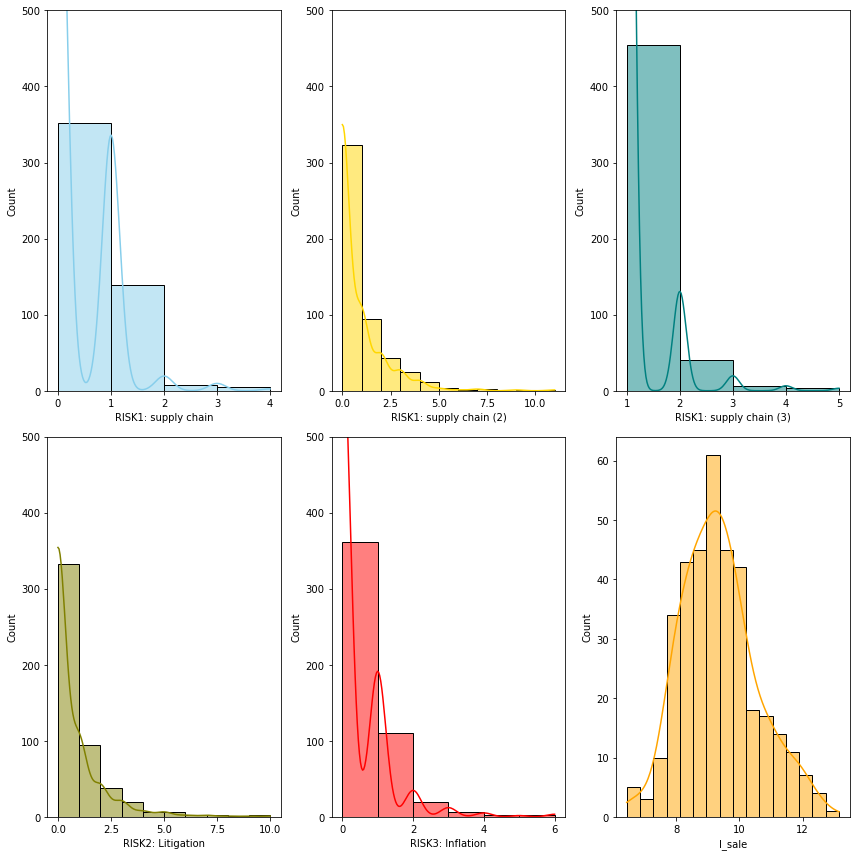

RISK1: supply chain (2)
0.0     323
1.0      94
2.0      43
3.0      24
4.0      12
5.0       3
6.0       1
7.0       2
9.0       1
11.0      1
Name: Symbol, dtype: int64

In [9]:

fig, axs = plt.subplots(2, 3, figsize=(12, 12))

sns.histplot(data=Sp500_acct_ret, x="RISK1: supply chain", kde=True, color="skyblue", ax=axs[0, 0], binwidth = 1)
sns.histplot(data=Sp500_acct_ret, x="RISK1: supply chain (2)", kde=True, color="gold", ax=axs[0, 1], binwidth = 1)
sns.histplot(data=Sp500_acct_ret, x="RISK1: supply chain (3)", kde=True, color="teal", ax=axs[0, 2], binwidth = 1)
sns.histplot(data=Sp500_acct_ret, x="RISK2: Litigation", kde=True, color="olive", ax=axs[1, 0], binwidth = 1)
sns.histplot(data=Sp500_acct_ret, x="RISK3: Inflation", kde=True, color="red", ax=axs[1, 1], binwidth = 1)
sns.histplot(data=Sp500_acct_ret, x="l_sale", kde=True, color="orange", ax=axs[1, 2])

axs[0,0].set_ylim(0,500)
axs[0,1].set_ylim(0,500)
axs[0,2].set_ylim(0,500)
axs[1,0].set_ylim(0,500)
axs[1,1].set_ylim(0,500)

fig.tight_layout() #create a space between each subplot


plt.rcParams.update({'font.size': 14})



plt.show()
Sp500_acct_ret.groupby(['RISK1: supply chain (2)'])['Symbol'].count()


### Findings

At first glance from looking at the table below, we can see that the correlation between gross returns and some of our risk measures, both qualitative and accounting, are very weak relationships. 

In [10]:
Sp500_acct_ret[['RISK1: supply chain', 'RISK1: supply chain (2)', 'RISK1: supply chain (3)', 'RISK2: Litigation', 'RISK3: Inflation', 'cash_a', 'l_sale', 'Inv', 'me', 'Gross_Ret']].corr()

,RISK1: supply chain,RISK1: supply chain (2),RISK1: supply chain (3),RISK2: Litigation,RISK3: Inflation,cash_a,l_sale,Inv,me,Gross_Ret
RISK1: supply chain,1.000000,0.739739,0.597548,0.593009,0.532725,0.155544,0.389143,-0.038662,0.482320,0.067947
RISK1: supply chain (2),0.739739,1.000000,0.550901,0.776659,0.655545,0.107867,0.366689,-0.016638,0.446665,0.075012
RISK1: supply chain (3),0.597548,0.550901,1.000000,0.497985,0.426632,0.142575,0.364324,-0.060374,0.454305,0.119452
RISK2: Litigation,0.593009,0.776659,0.497985,1.000000,0.766356,0.152890,0.331606,-0.019598,0.456686,0.058036
RISK3: Inflation,0.532725,0.655545,0.426632,0.766356,1.000000,0.116303,0.299242,-0.009799,0.432806,0.072225
cash_a,0.155544,0.107867,0.142575,0.152890,0.116303,1.000000,-0.250128,-0.020725,0.175969,0.170196
l_sale,0.389143,0.366689,0.364324,0.331606,0.299242,-0.250128,1.000000,-0.159047,0.507318,0.005891
Inv,-0.038662,-0.016638,-0.060374,-0.019598,-0.009799,-0.020725,-0.159047,1.000000,-0.032352,-0.124968
me,0.482320,0.446665,0.454305,0.456686,0.432806,0.175969,0.507318,-0.032352,1.000000,0.176773
Gross_Ret,0.067947,0.075012,0.119452,0.058036,0.072225,0.170196,0.005891,-0.124968,0.176773,1.000000


An interesting finding was that as the number of risk warnings increase, the variation on firm returns decrease. One can easily see this in the first set of scatterplots below, but I also included a line graph to visualize that the variation decreases as the risk count increases. 

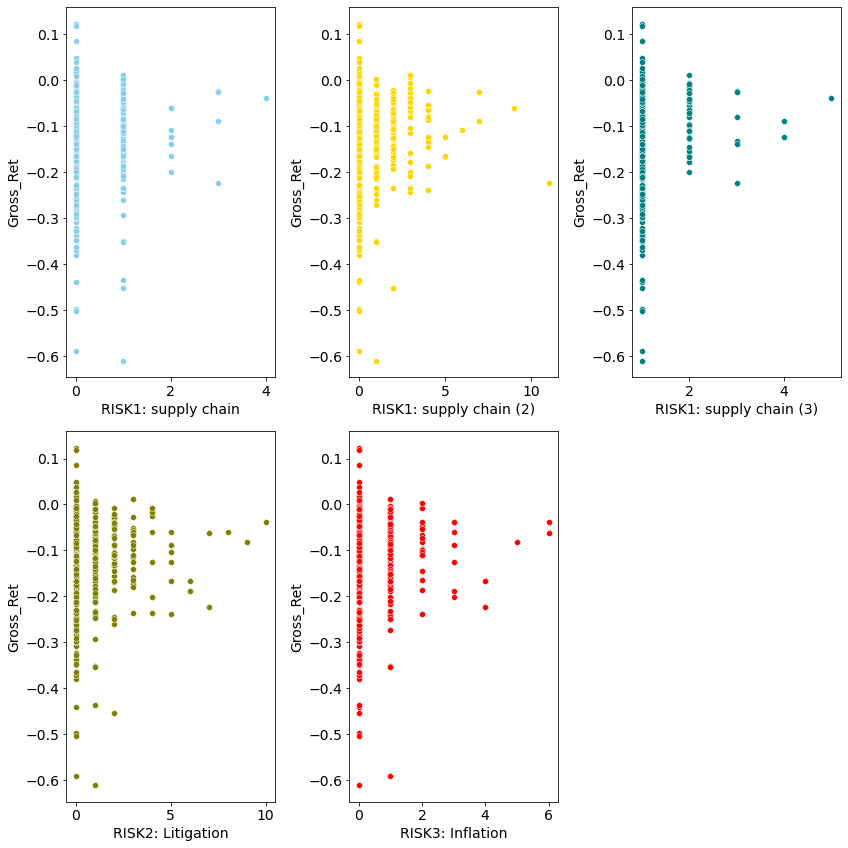

In [11]:

fig, axs = plt.subplots(2, 3, figsize=(12, 12))

sns.scatterplot(data=Sp500_acct_ret, x="RISK1: supply chain", y='Gross_Ret', color="skyblue", ax=axs[0, 0])
sns.scatterplot(data=Sp500_acct_ret, x="RISK1: supply chain (2)", y='Gross_Ret', color="gold", ax=axs[0, 1])
sns.scatterplot(data=Sp500_acct_ret, x="RISK1: supply chain (3)", y='Gross_Ret', color="teal", ax=axs[0, 2])
sns.scatterplot(data=Sp500_acct_ret, x="RISK2: Litigation", y='Gross_Ret', color="olive", ax=axs[1, 0])
sns.scatterplot(data=Sp500_acct_ret, x="RISK3: Inflation", y='Gross_Ret', color="red", ax=axs[1, 1])
sns.scatterplot(data=Sp500_acct_ret, x="l_sale", y='Gross_Ret', color="orange", ax=axs[1, 2])

fig.delaxes(axs[1,2]) #remove extra subplot 
plt.rcParams.update({'font.size': 14}) #make font size 14
fig.tight_layout() #create space between subplots 


plt.show()



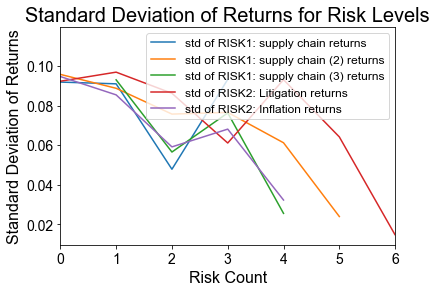

In [12]:
sd_a=Sp500_acct_ret.groupby(['RISK1: supply chain'])['Gross_Ret'].std()
sd_b=Sp500_acct_ret.groupby(['RISK1: supply chain (2)'])['Gross_Ret'].std()
sd_c=Sp500_acct_ret.groupby(['RISK1: supply chain (3)'])['Gross_Ret'].std()
sd_d=Sp500_acct_ret.groupby(['RISK2: Litigation'])['Gross_Ret'].std()
sd_e=Sp500_acct_ret.groupby(['RISK3: Inflation'])['Gross_Ret'].std()

plt.plot(sd_a,label='std of RISK1: supply chain returns')
plt.plot(sd_b, label='std of RISK1: supply chain (2) returns')
plt.plot(sd_c, label='std of RISK1: supply chain (3) returns')
plt.plot(sd_d, label = 'std of RISK2: Litigation returns')
plt.plot(sd_e, label = 'std of RISK2: Inflation returns')

plt.legend(loc="upper right",fontsize=12)
plt.xlim(0, 6)
plt.xlabel('Risk Count', fontsize=16)
plt.ylabel('Standard Deviation of Returns', fontsize=16)
plt.title('Standard Deviation of Returns for Risk Levels', fontsize=20)
sns.set({"figure.figsize": (12,8)}) 

plt.show()

Looking at the various boxplots, we get a better idea of some summary statistics. I first notice that we can see that the variation decreases as we increase our risk count. Another finding was that there are more outliers when there is a lower risk value. Most of the outliers also seem to be on the bottom end of the diagram. The size of the IQR for each risk level is roughly the same, but the range and the median seem to vary with each change in risk count.

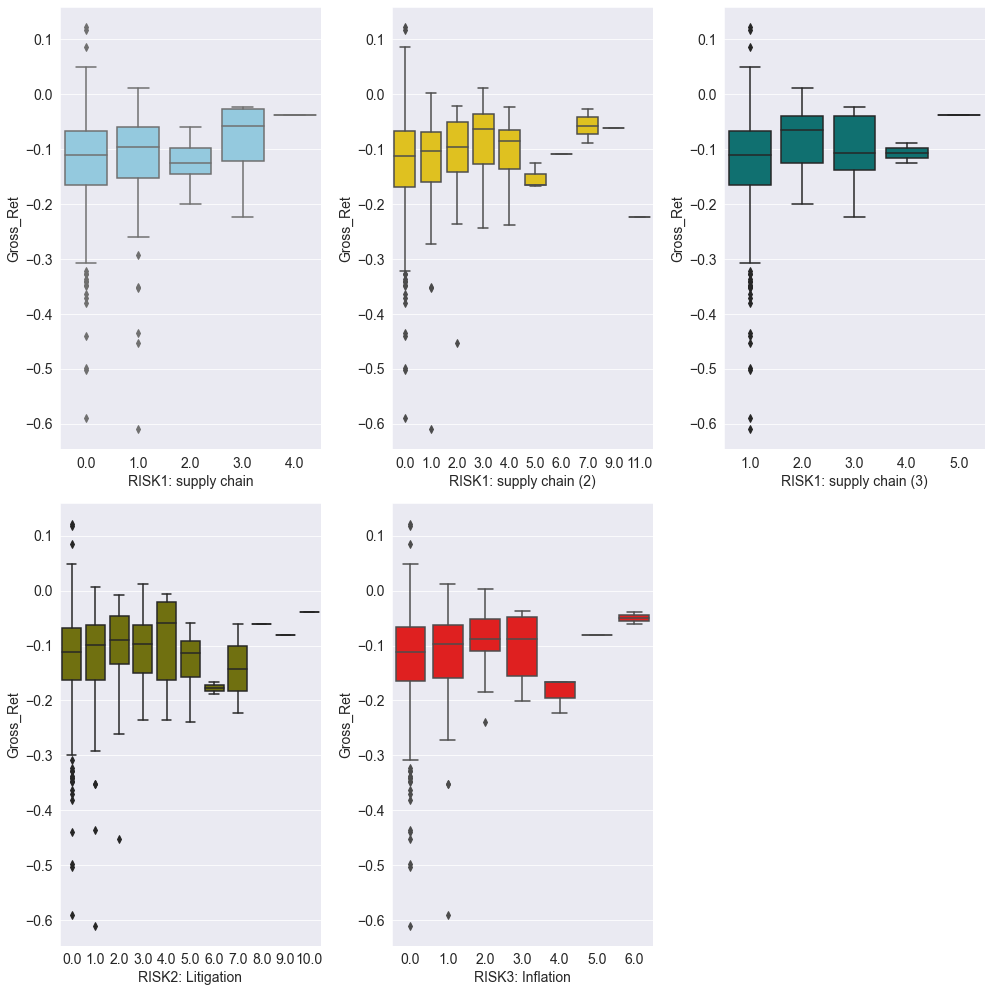

In [13]:

fig, axs = plt.subplots(2, 3, figsize=(14, 14))

sns.boxplot(data=Sp500_acct_ret, x="RISK1: supply chain", y='Gross_Ret', color="skyblue", ax=axs[0, 0])
sns.boxplot(data=Sp500_acct_ret, x="RISK1: supply chain (2)", y='Gross_Ret', color="gold", ax=axs[0, 1])
sns.boxplot(data=Sp500_acct_ret, x="RISK1: supply chain (3)", y='Gross_Ret', color="teal", ax=axs[0, 2])
sns.boxplot(data=Sp500_acct_ret, x="RISK2: Litigation", y='Gross_Ret', color="olive", ax=axs[1, 0])
sns.boxplot(data=Sp500_acct_ret, x="RISK3: Inflation", y='Gross_Ret', color="red", ax=axs[1, 1])
#sns.boxplot(data=Sp500_acct_ret, x="l_sale", y='Gross_Ret', color="orange", ax=axs[1, 2])

fig.delaxes(axs[1,2])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.rcParams.update({'font.size': 14})




plt.show()



### Relationship Between Risk Values and Stock Returns (Regression)

We now have all the necessary data to explore the relationship between our risk measurements and gross returns. Looking at the regression plots, one can see that the regression line (slope) is increasing, implying that the higher the risk the greater the return. However, before making this claim, we need to see the significance of this relationship. 

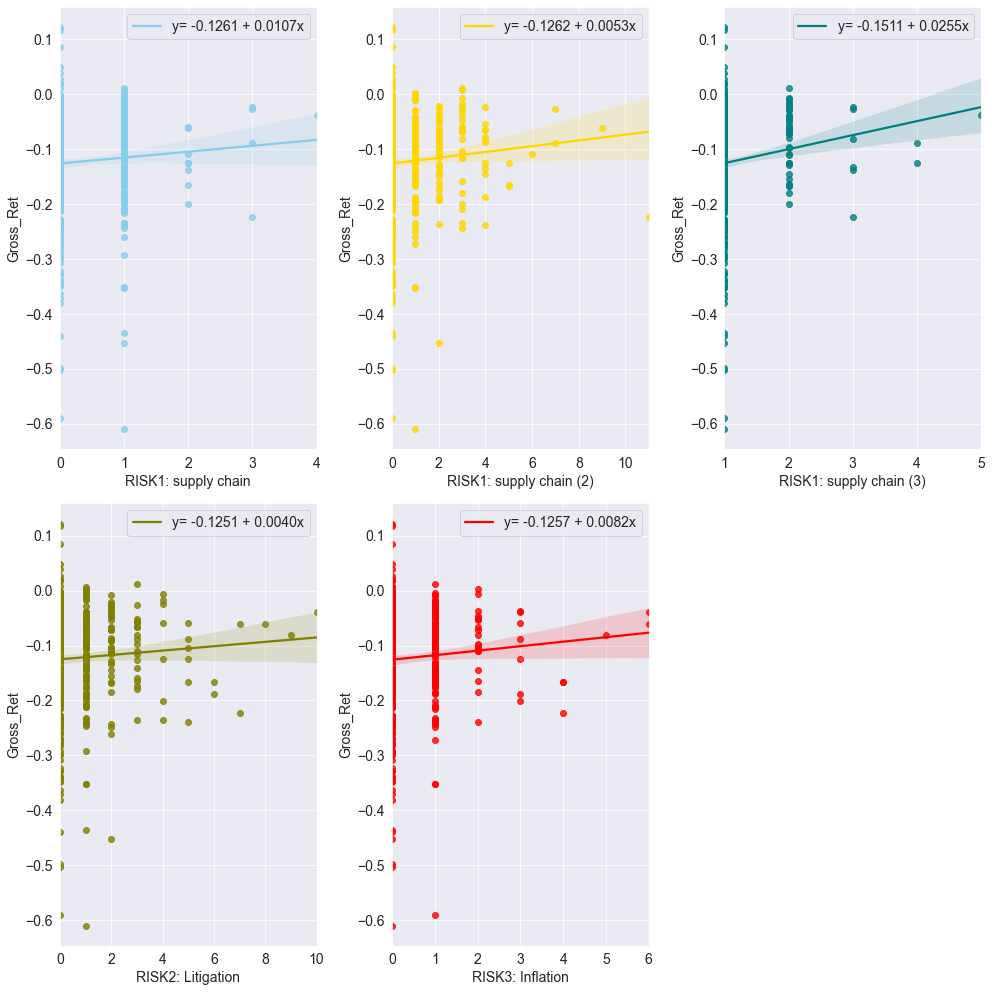

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(14, 14)) #nrows, ncolumns

sns.regplot(data=Sp500_acct_ret, x="RISK1: supply chain", y='Gross_Ret', color="skyblue", ax=axs[0, 0])
sns.regplot(data=Sp500_acct_ret, x="RISK1: supply chain (2)", y='Gross_Ret', color="gold", ax=axs[0, 1])
sns.regplot(data=Sp500_acct_ret, x="RISK1: supply chain (3)", y='Gross_Ret', color="teal", ax=axs[0, 2])
sns.regplot(data=Sp500_acct_ret, x="RISK2: Litigation", y='Gross_Ret', color="olive", ax=axs[1, 0])
sns.regplot(data=Sp500_acct_ret, x="RISK3: Inflation", y='Gross_Ret', color="red", ax=axs[1, 1])
#sns.regplot(data=Sp500_acct_ret, x="l_sale", y='Gross_Ret', color="orange", ax=axs[1, 2])

#ax.set(xlabel='Number of Risk Warnings', ylabel='Returns', title='Risk and Return (Mar9-13)')
#ax = sns.set({"figure.figsize": (7,5)}) 

x=Sp500_acct_ret['RISK1: supply chain']
x1=Sp500_acct_ret['RISK1: supply chain (2)']
x2=Sp500_acct_ret['RISK1: supply chain (3)']
x3=Sp500_acct_ret['RISK2: Litigation']
x4=Sp500_acct_ret['RISK3: Inflation']
y=Sp500_acct_ret['Gross_Ret']

mask = ~np.isnan(x) & ~np.isnan(x1) & ~np.isnan(x2) & ~np.isnan(x3) & ~np.isnan(x4) & ~np.isnan(y) #masking null values 
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1[mask], y[mask])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2[mask], y[mask])
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3[mask], y[mask])
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(x4[mask], y[mask])


axs[0,0].legend(['y= {:.4f} + {:.4f}x'.format(intercept,slope)], fontsize=14)
axs[0,1].legend(['y= {:.4f} + {:.4f}x'.format(intercept1,slope1)], fontsize=14)
axs[0,2].legend(['y= {:.4f} + {:.4f}x'.format(intercept2,slope2)], fontsize=14)
axs[1,0].legend(['y= {:.4f} + {:.4f}x'.format(intercept3,slope3)], fontsize=14)
axs[1,1].legend(['y= {:.4f} + {:.4f}x'.format(intercept4,slope4)], fontsize=14)

fig.delaxes(axs[1,2])
fig.tight_layout() 
plt.rcParams.update({'font.size': 14})



plt.show()

In [15]:
#model1 = sm_ols('Gross_Ret ~ Q("RISK1: supply chain") + Q("RISK1: supply chain (2)") + Q("RISK1: supply chain (3)") + Q("RISK2: Litigation") + Q("RISK3: Inflation")',data=Sp500_acct_ret)  #syntax to make it work 
model1 = sm_ols('Gross_Ret ~ Q("RISK1: supply chain")',data=Sp500_acct_ret)  #syntax to make it work 
results1 = model1.fit()             
print(results1.summary())           
#y_predicted1 = results1.predict()   
#residuals1 = results1.resid         
#residuals1 = y - y_predicted1     
#print('\n\nParams:')
#print(results1.params)



                            OLS Regression Results                            
Dep. Variable:              Gross_Ret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.282
Date:                Fri, 02 Apr 2021   Prob (F-statistic):              0.132
Time:                        16:16:01   Log-Likelihood:                 484.71
No. Observations:                 494   AIC:                            -965.4
Df Residuals:                     492   BIC:                            -957.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Looking at the table below, we get a better idea of our results. We fist note that our correlation coefficient (r) is extremely weak, implying that there is no correlation between our risk measures and gross returns. 

When we consider the p value, we are assuming that our hypothesis is that the beta coefficient is zero. Thus, if the p value is less than 0.05, we can reject the hypothesis and claim with that the beta coefficient (slope) is not zero, hence implying a relationship. Only RISK1: supply chain (3) has a p value less than 0.05 so this is the only variable where we can reject our hypothesis and conclude that there is a relationship. 

In [16]:
d = {'r': [r_value,r_value1,r_value2,r_value3,r_value4], 
     'p value': [p_value,p_value1,p_value2,p_value3,p_value4], 
     'std error': [std_err,std_err1,std_err2,std_err3,std_err4], 
     'slope': [slope,slope1,slope2,slope3,slope4], 
     'intercept': [intercept,intercept1,intercept2,intercept3,intercept4],
    'Risks' : ['RISK1: supply chain', 'RISK1: supply chain (2)', 'RISK1: supply chain (3)', 'RISK2: Litigation', 'RISK3: Inflation']}
df = pd.DataFrame(data=d)
df.index = df["Risks"]
del df['Risks']

df

,r,p value,std error,slope,intercept
Risks,,,,,
RISK1: supply chain,0.067947,0.131524,0.007108,0.010738,-0.126108
RISK1: supply chain (2),0.075012,0.095842,0.003152,0.005259,-0.126171
RISK1: supply chain (3),0.119452,0.007867,0.009562,0.025519,-0.151083
RISK2: Litigation,0.058036,0.197838,0.003096,0.003992,-0.125136
RISK3: Inflation,0.072225,0.108868,0.005105,0.008199,-0.125716


Acting as a validation check, we can compare the correlation coefficient (r) that we found in our regression analysis with our correlation coefficient from our original dataset. We see that the values match up, a sign that it was calculated correctly. 

In [17]:
Sp500_acct_ret[['RISK1: supply chain', 'RISK1: supply chain (2)', 'RISK1: supply chain (3)', 'RISK2: Litigation', 'RISK3: Inflation', 'Gross_Ret']].corr()

,RISK1: supply chain,RISK1: supply chain (2),RISK1: supply chain (3),RISK2: Litigation,RISK3: Inflation,Gross_Ret
RISK1: supply chain,1.000000,0.739739,0.597548,0.593009,0.532725,0.067947
RISK1: supply chain (2),0.739739,1.000000,0.550901,0.776659,0.655545,0.075012
RISK1: supply chain (3),0.597548,0.550901,1.000000,0.497985,0.426632,0.119452
RISK2: Litigation,0.593009,0.776659,0.497985,1.000000,0.766356,0.058036
RISK3: Inflation,0.532725,0.655545,0.426632,0.766356,1.000000,0.072225
Gross_Ret,0.067947,0.075012,0.119452,0.058036,0.072225,1.000000


Looking at the correlation matrix, it is interesting to see the correlation RISK2: Litigation has with RISK1: supply chain (2) and RISK3: Inflation. Correlations of 0.77 and 0.78 indicate a high relationship. Simply looking at the data we would conclude that Litigation is linked to supply chain and inflation but I am expecting this to be an error due to the lack of textual information each wiki page contained. 

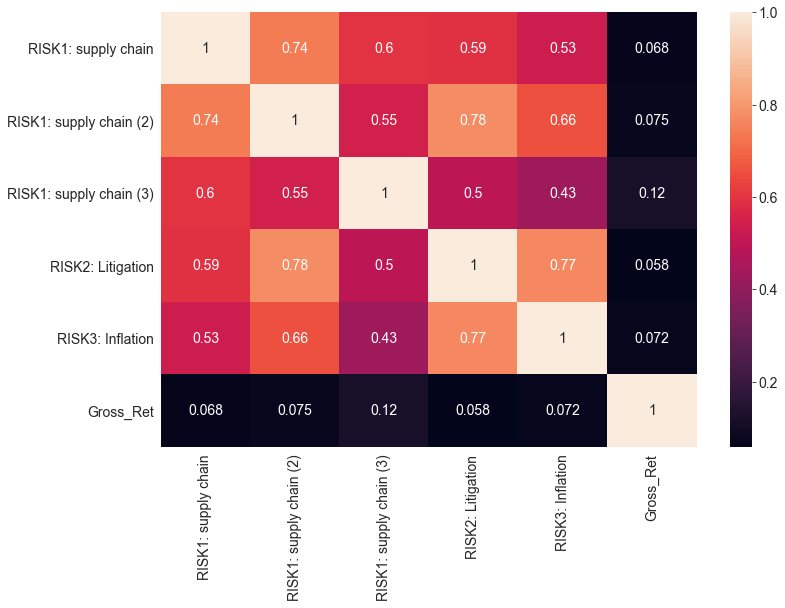

In [18]:
corrMatrix = Sp500_acct_ret[['RISK1: supply chain', 'RISK1: supply chain (2)', 'RISK1: supply chain (3)', 'RISK2: Litigation', 'RISK3: Inflation', 'Gross_Ret']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.rcParams.update({'font.size': 14})
plt.show()

### Conclusion

Greatest findings
- Searching through wiki pages to gather information is not reliable 
- The variation of returns decrease as we increase our risk count
- Most of our risk measures are statistically insignificant and all of them have a weak relationship with gross returns
- Litigation Risk seems to have a high correlation with Inflation and Supply Chain (2) Risk
- The slope between risk and return are all positive (indicating higher risk = higher reward)


### BONUS ESTIMATING ALPHA



I am estimating the alpha of each firm's return.

In [19]:
#crsp = pd.read_stata('https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/3firm_ret_1990_2020.dta?raw=true')

#returns['ret'] = returns['ret']*100 # convert to precentage to match FF's convention on scaling (daily % rets)
#crsp['date'] = pd.to_datetime(crsp['date'], format='%Y%m%d', errors='coerce') #change dates format 
#returns['year'] = returns['date'].date.dt.year

#crsp.groupby(by=[crsp.index.year])
# crsp.index = pd.to_datetime(crsp['date'],format='%m/%d/%y %I:%M%p')
# crsp.groupby(by=[crsp.index.year])

returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format 
returns['ret'] = returns['ret'].apply(pd.to_numeric, errors='coerce') #had to change the ret to numeric values 
#returns['year'] = returns['date'].dt.year
returns['ret'] = returns['ret']*100 # convert to precentage to match FF's convention on scaling (daily % rets)


returns.head()

,permno,date,ticker,comnam,primexch,prc,ret,shrout,vwretd,_merge,Gross_Ret
0,10026,2019-10-25,JJSF,J & J SNACK FOODS CORP,Q,188.960007,-0.5997,18895.0,0.004069,matched (3),0.994003
1,10026,2020-03-11,JJSF,J & J SNACK FOODS CORP,Q,146.199997,-6.6232,18919.0,-0.049958,matched (3),0.933768
2,10026,2020-01-08,JJSF,J & J SNACK FOODS CORP,Q,182.039993,-0.5409,18900.0,0.004028,matched (3),0.994591
3,10026,2020-04-13,JJSF,J & J SNACK FOODS CORP,Q,121.930000,-4.5334,18888.0,-0.010146,matched (3),0.954666
4,10026,2020-06-02,JJSF,J & J SNACK FOODS CORP,Q,128.740005,-1.8076,18888.0,0.008413,matched (3),0.981924


In [20]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=1980,end=2021)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"}) #get it in decimal format, smale to dataset above 
ff

,date,mkt_excess,SMB,HML,RMW,CMA,RF
0,1980-01-02,-2.05,0.18,1.09,-1.10,0.75,0.036
1,1980-01-03,-0.73,-0.88,0.33,-0.27,0.17,0.036
2,1980-01-04,1.32,0.61,-0.40,-0.13,-0.59,0.036
3,1980-01-07,0.39,0.26,0.02,-0.45,0.06,0.036
4,1980-01-08,1.92,-0.32,-0.71,0.69,-0.36,0.036
...,...,...,...,...,...,...,...
10335,2020-12-24,0.21,-0.43,-0.17,0.24,-0.05,0.000
10336,2020-12-28,0.46,-0.65,0.32,1.46,0.50,0.000
10337,2020-12-29,-0.40,-1.42,0.24,0.75,-0.28,0.000
10338,2020-12-30,0.27,1.03,0.04,-0.67,-0.06,0.000


In [21]:
crsp_ready = pd.merge(left=ff, right=returns, on='date', how="inner", validate="one_to_many")
crsp_ready

,date,mkt_excess,SMB,HML,RMW,CMA,RF,permno,ticker,comnam,primexch,prc,ret,shrout,vwretd,_merge,Gross_Ret
0,2019-01-02,0.23,0.72,1.1,-0.12,0.26,0.01,10026,JJSF,J & J SNACK FOODS CORP,Q,141.000000,-2.4829,18774.0,0.001791,matched (3),0.975171
1,2019-01-02,0.23,0.72,1.1,-0.12,0.26,0.01,10032,PLXS,PLEXUS CORP,Q,51.740002,1.2921,30992.0,0.001791,matched (3),1.012921
2,2019-01-02,0.23,0.72,1.1,-0.12,0.26,0.01,10104,ORCL,ORACLE CORP,N,45.220001,0.1550,3588919.0,0.001791,matched (3),1.001550
3,2019-01-02,0.23,0.72,1.1,-0.12,0.26,0.01,10107,MSFT,MICROSOFT CORP,Q,101.120003,-0.4430,7683000.0,0.001791,matched (3),0.995570
4,2019-01-02,0.23,0.72,1.1,-0.12,0.26,0.01,10138,TROW,T ROWE PRICE GROUP INC,Q,91.839996,-0.5199,238069.0,0.001791,matched (3),0.994801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724220,2020-06-30,1.58,-0.01,0.0,-0.39,-0.27,0.00,93422,QEP,Q E P RESOURCES INC,N,1.290000,2.3810,242182.0,0.014671,matched (3),1.023810
724221,2020-06-30,1.58,-0.01,0.0,-0.39,-0.27,0.00,93423,SIX,SIX FLAGS ENTERTAINMENT CORP,N,19.209999,-0.9283,84687.0,0.014671,matched (3),0.990717
724222,2020-06-30,1.58,-0.01,0.0,-0.39,-0.27,0.00,93427,FN,FABRINET,N,62.419998,3.6877,36722.0,0.014671,matched (3),1.036877
724223,2020-06-30,1.58,-0.01,0.0,-0.39,-0.27,0.00,93429,CBOE,C B O E GLOBAL MARKETS INC,B,93.279999,0.5064,109720.0,0.014671,matched (3),1.005064


In [22]:
def reg_in_groupby(df,formula="ret_excess ~ mkt_excess + SMB + HML"):
    '''
    Want to run regressions after groupby?
    
    This will do it! 
    
    Note: This defaults to a FF3 model assuming specific variable names. If you
    want to run any other regression, just specify your model.
    
    Usage: 
        df.groupby(<whatever>).apply(reg_in_groupby)
        df.groupby(<whatever>).apply(reg_in_groupby,formula=<whatever>)
    '''
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)

In [23]:
data = (
    crsp_ready # grab the data
    
    # Two things before the regressions:
    # 1. need a year variable (to group on)
    # 2. the market returns in FF are excess returns, so 
    #    our stock returns need to be excess as well
    .assign(year = crsp_ready.date.dt.year,
           ret_excess = crsp_ready.ret - crsp_ready.RF)
    
    # ok, run the regs, so easy!
    .groupby(['permno', 'year']).apply(reg_in_groupby)
    
    # and clean up - with better var names
    .rename(columns={'mkt_excess':'mkt_beta','SMB':'SMB_beta','HML':'HML_beta'})
    .reset_index()
 
)
data

,permno,year,Intercept,mkt_beta,SMB_beta,HML_beta
0,10026,2019,0.091995,0.139407,0.744954,-0.356432
1,10026,2020,-0.111215,1.017147,0.578898,0.292377
2,10032,2019,0.072451,1.124696,0.718146,0.100715
3,10032,2020,0.066688,0.876231,2.094904,-0.175944
4,10104,2019,-0.034981,1.061817,-0.208843,0.181214
...,...,...,...,...,...,...
3911,93427,2020,-0.029564,0.901695,0.568288,-0.249634
3912,93429,2019,0.038170,0.288178,-0.713934,-0.135651
3913,93429,2020,-0.208165,0.850575,0.744067,-0.341075
3914,93436,2019,0.013494,1.164662,0.822647,-0.441555


In [29]:
Alpha = pd.merge(crsp_ready,data.query('year==2019'), on='permno')
Alpha['ret_excess'] = Alpha['ret'] - Alpha['RF']
Alpha['alpha'] = Alpha['ret_excess']- Alpha['mkt_beta']*Alpha['mkt_excess'] - Alpha['HML_beta']*Alpha['HML'] - Alpha['SMB_beta']*Alpha['SMB']
Alpha.describe()

,mkt_excess,SMB,HML,RMW,CMA,RF,permno,prc,ret,shrout,vwretd,Gross_Ret,year,Intercept,mkt_beta,SMB_beta,HML_beta,ret_excess,alpha
count,722987.000000,722987.000000,722987.000000,722987.000000,722987.000000,722987.000000,722987.000000,722894.000000,722854.000000,7.229030e+05,722987.000000,722854.000000,722987.0,722987.000000,722987.000000,722987.000000,722987.000000,722854.000000,722854.000000
mean,0.075148,-0.029264,-0.107553,0.003654,-0.026529,0.006671,54913.901664,245.628311,0.078168,2.985947e+05,0.000740,1.000782,2019.0,0.023294,0.897390,0.306736,0.009484,0.071497,0.013853
std,1.791757,0.798600,1.104940,0.426274,0.341474,0.003286,33261.382529,7024.819824,3.160519,6.221312e+05,0.017393,0.031605,0.0,0.106887,0.500601,0.557261,0.653575,3.160594,2.525064
min,-12.000000,-4.580000,-4.710000,-1.790000,-1.570000,0.000000,10026.000000,-52.070000,-86.666700,6.930000e+02,-0.118168,0.133333,2019.0,-0.492447,-5.517539,-1.025567,-8.233117,-86.672700,-93.813518
25%,-0.400000,-0.410000,-0.560000,-0.230000,-0.230000,0.006000,16383.000000,29.299999,-0.877900,6.287500e+04,-0.003516,0.991221,2019.0,-0.020668,0.615844,-0.057655,-0.328044,-0.884800,-0.711251
50%,0.150000,-0.070000,-0.120000,0.000000,-0.030000,0.007000,68144.000000,53.220001,0.091500,1.285900e+05,0.001289,1.000915,2019.0,0.018030,0.931850,0.179573,0.003445,0.084200,0.007795
75%,0.730000,0.360000,0.370000,0.240000,0.170000,0.009000,88182.000000,97.177498,1.074400,2.805530e+05,0.006696,1.010744,2019.0,0.067025,1.219898,0.576826,0.363147,1.067275,0.710984
max,9.340000,5.730000,4.590000,1.700000,1.450000,0.010000,93436.000000,344970.000000,216.666700,9.814197e+06,0.091556,3.166667,2019.0,2.956067,3.455900,12.467395,3.093920,216.660700,215.721207


In [25]:
Alpha['Gross_Alpha'] = 1 + Alpha['alpha']

subsample = (Alpha[(Alpha['date'] >= '2020-03-09') & (Alpha['date'] <= '2020-03-13')]) #group returns data within a time range 

Week_alpha = (subsample.groupby(['ticker'])['Gross_Alpha'].prod()-1).reset_index() #Gross Returns 
Week_alpha

Sp500_acct_final = pd.merge(Sp500_acct_ret, Week_alpha[['ticker','Gross_Alpha']], on='ticker')
Sp500_acct_final

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded,url,...,xrd_a,dltt_a,invopps_FG09,sales_g,dv_a,short_debt,ticker,Gross_Ret,_merge,Gross_Alpha
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902,https://en.wikipedia.org/wiki/3M,...,0.042791,0.408339,2.749554,NaN,0.074252,0.143810,MMM,-0.077905,both,-658.184433
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories,...,0.035942,0.256544,2.520681,NaN,0.033438,0.088120,ABT,-0.001101,both,8.147384
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie_Inc.,...,0.076216,0.709488,2.211589,NaN,0.071436,0.057566,ABBV,-0.038844,both,-21.511424
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,https://en.wikipedia.org/wiki/Abiomed,...,0.088683,0.000000,12.164233,NaN,0.000000,NaN,ABMD,-0.090781,both,236.094455
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,https://en.wikipedia.org/wiki/Accenture,...,0.026846,0.000545,4.241083,NaN,0.062583,0.282946,ACN,-0.068476,both,1.106663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,https://en.wikipedia.org/wiki/Yum!_Brands_Inc,...,0.000000,1.071959,8.046718,NaN,0.097687,0.044192,YUM,-0.122372,both,-107.003204
491,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,https://en.wikipedia.org/wiki/Zebra_Technologies,...,0.094884,0.250478,3.225952,NaN,0.000000,0.160740,ZBRA,-0.092335,both,-337.747043
492,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,https://en.wikipedia.org/wiki/Zimmer_Biomet,...,0.021081,0.281545,1.556915,NaN,0.007983,0.184000,ZBH,-0.211926,both,-25.378256
493,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,https://en.wikipedia.org/wiki/Zions_Bancorp,...,NaN,NaN,NaN,NaN,NaN,NaN,ZION,-0.166100,both,6.059682


In [26]:
Sp500_acct_final[['RISK1: supply chain (2)', 'RISK2: Litigation', 'RISK3: Inflation', 'cash_a', 'l_sale', 'Inv', 'me', 'Gross_Alpha']].corr()

,RISK1: supply chain (2),RISK2: Litigation,RISK3: Inflation,cash_a,l_sale,Inv,me,Gross_Alpha
RISK1: supply chain (2),1.000000,0.776108,0.654525,0.105819,0.370041,-0.019854,0.447548,-0.023451
RISK2: Litigation,0.776108,1.000000,0.767292,0.151420,0.334457,-0.022783,0.457824,0.005763
RISK3: Inflation,0.654525,0.767292,1.000000,0.113110,0.303127,-0.012722,0.432993,-0.008076
cash_a,0.105819,0.151420,0.113110,1.000000,-0.249887,-0.023326,0.175341,-0.007425
l_sale,0.370041,0.334457,0.303127,-0.249887,1.000000,-0.159149,0.507950,0.042950
Inv,-0.019854,-0.022783,-0.012722,-0.023326,-0.159149,1.000000,-0.033603,0.064084
me,0.447548,0.457824,0.432993,0.175341,0.507950,-0.033603,1.000000,0.006654
Gross_Alpha,-0.023451,0.005763,-0.008076,-0.007425,0.042950,0.064084,0.006654,1.000000


In [27]:
Sp500_acct_final[['RISK1: supply chain (2)', 'RISK2: Litigation', 'RISK3: Inflation', 'Gross_Alpha']].describe()

,RISK1: supply chain (2),RISK2: Litigation,RISK3: Inflation,Gross_Alpha
count,494.000000,494.000000,494.000000,495.000000
mean,0.714575,0.682186,0.402834,376.110370
std,1.298115,1.323146,0.801667,41862.877169
min,0.000000,0.000000,0.000000,-474931.391315
25%,0.000000,0.000000,0.000000,-108.320025
50%,0.000000,0.000000,0.000000,-1.945606
75%,1.000000,1.000000,1.000000,39.736638
max,11.000000,10.000000,6.000000,779419.721900
